In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
from time import sleep
from soccer import SoccerGame
from MARL_agent import MARLAgent, QLAgent
from tqdm.notebook import tqdm

## Functions

In [2]:
def plot_rewards(rewards, title, window_size=10):
    """
    Grafica la recompensa por episodio y su media móvil.
    
    :param rewards: Lista de recompensas obtenidas en cada episodio.
    :param window_size: Tamaño de la ventana para el promedio móvil.
    """
    episodes = np.arange(len(rewards))
    
    # Cálculo del promedio móvil
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, rewards, label='Recompensa por episodio', alpha=0.5)
    plt.plot(episodes[:len(smoothed_rewards)], smoothed_rewards, label=f'Promedio móvil (window={window_size})', color='red', linewidth=2)
    
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
def run_minimax_training(steps, player = 'A', opponent = 'random', pi_table = {}):
    # player and opponent actions
    actions = ['N', 'S', 'E', 'W', 'stand']
    opponent_actions = ['N', 'S', 'E', 'W', 'stand']

    # Agent creation
    agent = MARLAgent(actions, opponent_actions, epsilon=0.2)
    if opponent == 'minimax':
        agent2 = MARLAgent(opponent_actions, actions, epsilon=0.2)

    # Game creation
    game = SoccerGame()
    game.print_state() # print initial state of the game 

    # Initial state
    state0 = ((1,3),(2,1),game.ball_possession)
    state = state0

    # Initialization of some variables
    i = 0
    count = 0
    cum_reward = 0
    hist_reward = []

    # Progress bar
    with tqdm(total=steps, desc="Progreso", unit="step") as pbar:
        # Number of steps
        while i < steps:
            # Choose the player action 
            action = str(agent.choose_action(state))

            # Choose the opponent action
            if opponent == 'random':
                opponent_action = random.choice(opponent_actions)
            elif opponent == 'pi_table':
                o = np.argmax(list(pi_table[state].values()))
                opponent_action = opponent_actions[o]
            elif opponent == 'minimax':
                opponent_action = str(agent2.choose_action(state))
            
            # Evaluation if the agent A or agent B is the player
            if player == 'A':
                joint_action = {'A': action, 'B': opponent_action}
            elif player == 'B':
                joint_action = {'A': opponent_action, 'B': action}
            
            # Play game
            new_state, reward, done = game.play_turn(joint_action)

            # Cumulative rewardagent = MARLAgent(actions, opponent_actions, epsilon=0.2)
            cum_reward += reward[player]

            # Save the cumulative reward every 1000 steps
            if i % 1e3 == 0:
                hist_reward.append(cum_reward)
                cum_reward = 0

            # Make a goal
            if done == True:
                count += 1
            
            # Update agent parameters
            agent.update(state, action, opponent_action,  reward, new_state, agent=player )
            if opponent == 'minimax':
                agent2.update(state, opponent_action, action,  reward, new_state, agent=player )
            state = new_state
            i += 1
            pbar.update(1)  # Actualiza la barra en cada paso
        print(f'Played games: {count}')
        if opponent == 'minimax':
            return hist_reward, agent.pi_table, agent2.pi_table
        else:
            return hist_reward, agent.pi_table

In [14]:
def run_validation(pi_table, player = 'A', render = False, opponent = 'random', pi_table_opponent = {}):
    game = SoccerGame()
    game.print_state()

    state0 = ((1,3),(2,1),game.ball_possession)
    state = state0

    actions = ['N', 'S', 'E', 'W', 'stand']
    opponent_actions = ['N', 'S', 'E', 'W', 'stand']

    count = 0
    count_win = 0
    for i in range(100000):
        a = np.argmax(list(pi_table[state].values()))
        action = actions[a]
        
        if opponent == 'random':
            opponent_action = random.choice(opponent_actions)
        elif opponent == 'pi_table':
            o = np.argmax(list(pi_table_opponent[state].values()))
            opponent_action = opponent_actions[o] 

        if player == 'A':
            joint_action = {'A': action, 'B': opponent_action}
        elif player == 'B':
            joint_action = {'A': opponent_action, 'B': action}
            
        new_state, reward, done = game.play_turn(joint_action)
        if done == True:
            count += 1
            if reward[player] == 1:
                count_win += 1
            # 10% de probabilidad de empate
        if random.random() < 0.1:
            game.reset_pos()
            state = ((1,3),(2,1),game.ball_possession)
        else:
            state = new_state
        if render == True:
            game.print_state()
            sleep(0.5)

    print(f'Se completaron {count} juegos y se ganó el {count_win/count * 100}% ')

In [33]:
def run_qlearning_training(steps, player = 'A', opponent = 'random', pi_table = {}):
    # Example usage:
    actions = ['N', 'S', 'E', 'W', 'stand']
    opponent_actions = ['N', 'S', 'E', 'W', 'stand']

    ql_agent = QLAgent(actions, epsilon=0.2)
    if opponent == 'q-learning':
        ql_agent2 = QLAgent(opponent_actions, epsilon=0.2)
    ql_game = SoccerGame()
    ql_game.print_state()
    # Simulate a single step
    state0 = ((1,3),(2,1),ql_game.ball_possession)
    state = state0
    i = 0
    count = 0
    cum_reward = 0
    hist_reward = []
    with tqdm(total=steps, desc="Progreso", unit="step") as pbar:
        while i < steps:
            action = str(ql_agent.choose_action(state))
            if opponent == 'random':
                opponent_action = random.choice(opponent_actions)
            elif opponent == 'pi_table':
                o = np.argmax(list(pi_table[state].values()))
                opponent_action = opponent_actions[o]
            elif opponent == 'q-learning':
                opponent_action = str(ql_agent2.choose_action(state))

            if player == 'A':
                joint_action = {'A': action, 'B': opponent_action}
            elif player == 'B':
                joint_action = {'A': opponent_action, 'B': action}
            new_state, reward, done = ql_game.play_turn(joint_action)
        
            cum_reward += reward[player]

            if i % 1e3 == 0:
                hist_reward.append(cum_reward)
                cum_reward = 0

            if done == True:
                count += 1
                
            ql_agent.update(state, action,  reward, new_state, agent=player )
            if opponent == 'q-learning':
                ql_agent2.update(state, opponent_action,  reward, new_state, agent=player )
            state = new_state
            i += 1
            pbar.update(1)  # Actualiza la barra en cada paso
        print(f'Played games: {count}')
        
        if opponent == 'q-learning':
            return hist_reward, ql_agent.q_table, ql_agent2.q_table
        else:
            return hist_reward, ql_agent.q_table

# Minimax

## MR

In [6]:
mm_hist_reward, pi_table_mm = run_minimax_training(steps=1e6, player='A', opponent='random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 44546


In [7]:
with open("results/pi_table_MR.txt", "w") as f:
    f.write(str(pi_table_mm))

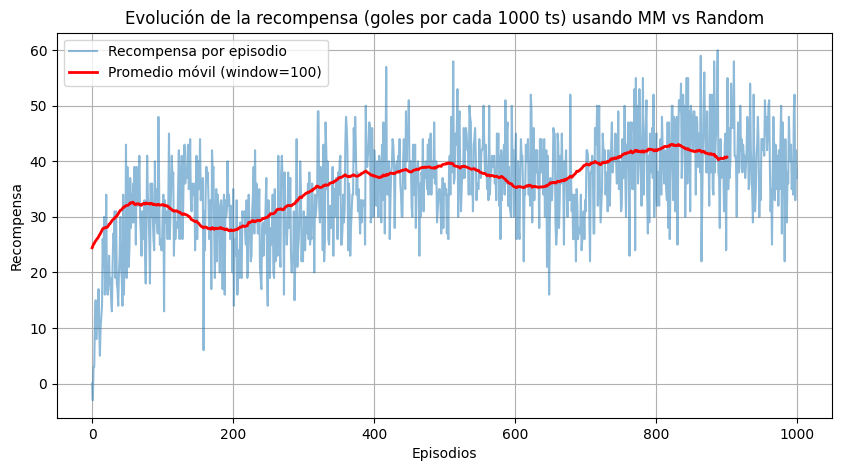

In [8]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando MM vs Random'
plot_rewards(mm_hist_reward,title, window_size=100)

### MR vs Random

In [9]:
run_validation(pi_table_mm, player='A', render = False, opponent = 'random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 7333 juegos y se ganó el 98.036274376108% 


## MR-Challenger 


In [10]:
with open("results/pi_table_MR.txt", "r") as f:
    contenido = f.read()
    pi_table_MR = eval(contenido)  # Convierte el texto de nuevo en un diccionario

In [11]:
hist_reward_MRC, pi_table_MRC = run_minimax_training(steps=1e6, player='B', opponent='pi_table', pi_table=pi_table_mm)

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 95664


In [46]:
with open("results/pi_table_MRC.txt", "w") as f:
    f.write(str(pi_table_MRC))

NameError: name 'pi_table_MRC' is not defined

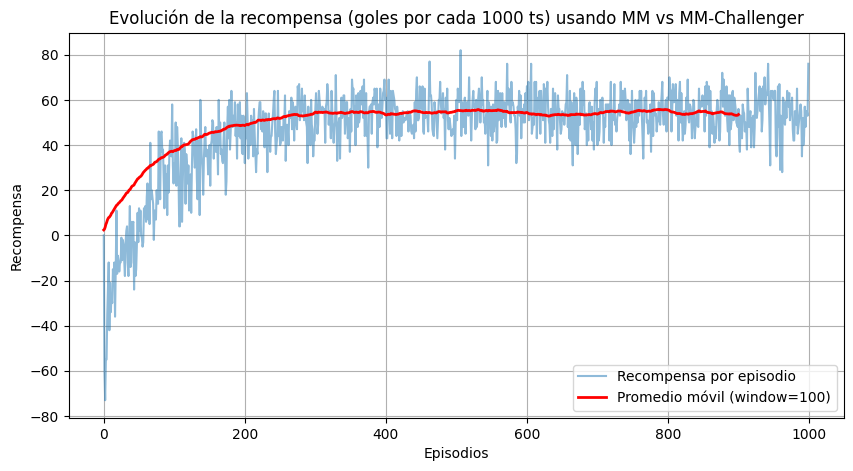

In [12]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando MM vs MM-Challenger'
plot_rewards(hist_reward_MRC,title, window_size=100)

In [13]:
run_validation(pi_table_MR, player='A', render = False, opponent = 'pi_table', pi_table_opponent= pi_table_MRC)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 8284 juegos y se ganó el 0.0% 


## MM

In [42]:
hist_reward_mm, pi_table1_mm, pi_table2_mm = run_minimax_training(steps=1e6, player='A', opponent='minimax')

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 91107


In [43]:
with open("results/pi_table_MM.txt", "w") as f:
    f.write(str(pi_table1_mm))

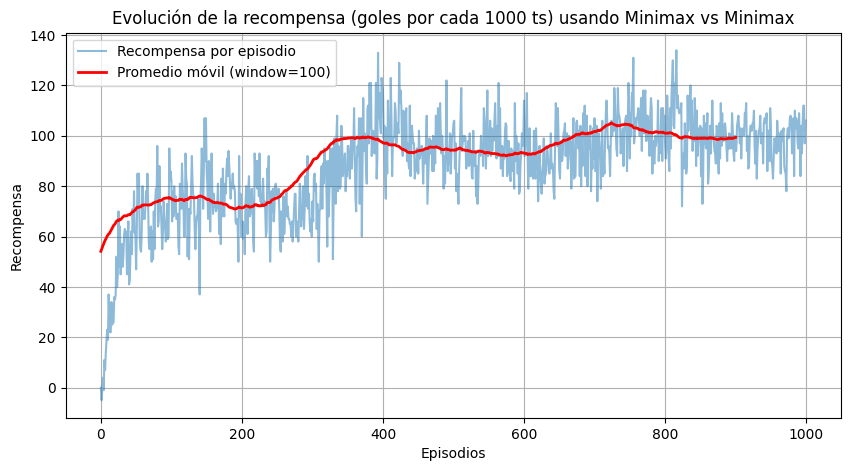

In [44]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando Minimax vs Minimax'
plot_rewards(hist_reward_mm,title, window_size=100)

In [45]:
run_validation(pi_table1_mm, player='A', render = False, opponent = 'random')

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 9029 juegos y se ganó el 97.02071104219736% 


## MM-Challenger

In [15]:
with open("results/pi_table_MM.txt", "r") as f:
    contenido = f.read()
    pi_table_MM = eval(contenido)  # Convierte el texto de nuevo en un diccionario

In [16]:
hist_reward_MMC, pi_table_MMC = run_minimax_training(steps=1e6, player='B', opponent='pi_table', pi_table=pi_table_MM)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 120140


In [47]:
with open("results/pi_table_MMC.txt", "w") as f:
    f.write(str(pi_table_MMC))

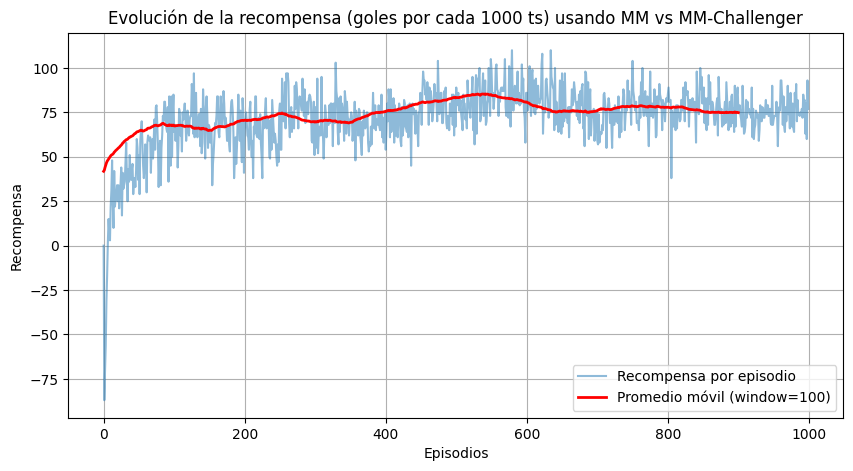

In [17]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando MM vs MM-Challenger'
plot_rewards(hist_reward_MMC,title, window_size=100)

In [18]:
run_validation(pi_table_MM, player='A', render = False, opponent = 'pi_table', pi_table_opponent= pi_table_MMC)

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 10539 juegos y se ganó el 0.0% 


# Q-Learning Algorithm

## QR

In [19]:
hist_reward_QR, q_table_QR = run_qlearning_training(steps=1e6, player='A', opponent='random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 108410


In [20]:
with open("results/q_table_QR.txt", "w") as f:
    f.write(str(q_table_QR))

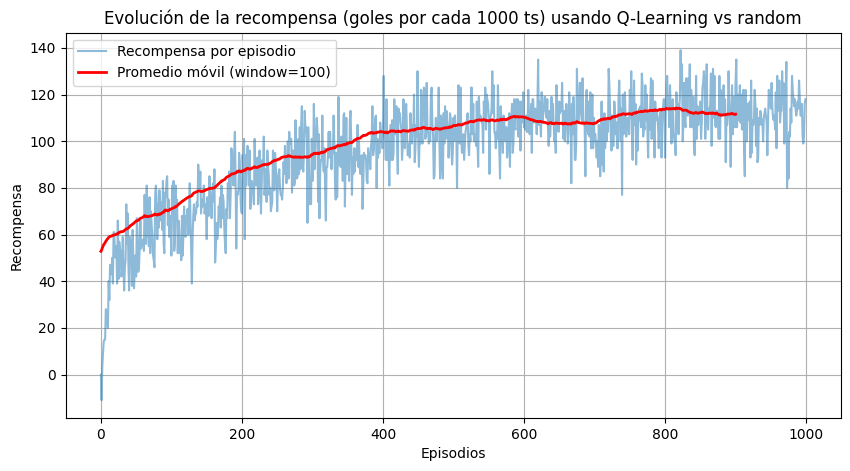

In [21]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando Q-Learning vs random'
plot_rewards(hist_reward_QR,title, window_size=100)

In [24]:
run_validation(q_table_QR, player='A',render = False, opponent = 'random' )

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 14273 juegos y se ganó el 97.68794226861907% 


## QR - Challenger

In [26]:
with open("results/q_table_QR.txt", "r") as f:
    contenido = f.read()
    Q_table_QR = eval(contenido)  # Convierte el texto de nuevo en un diccionario

In [27]:
hist_reward_QRC, pi_table_QRC = run_qlearning_training(steps=1e6, player='B', opponent='pi_table', pi_table=Q_table_QR)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 189829


In [48]:
with open("results/pi_table_QRC.txt", "w") as f:
    f.write(str(pi_table_QRC))

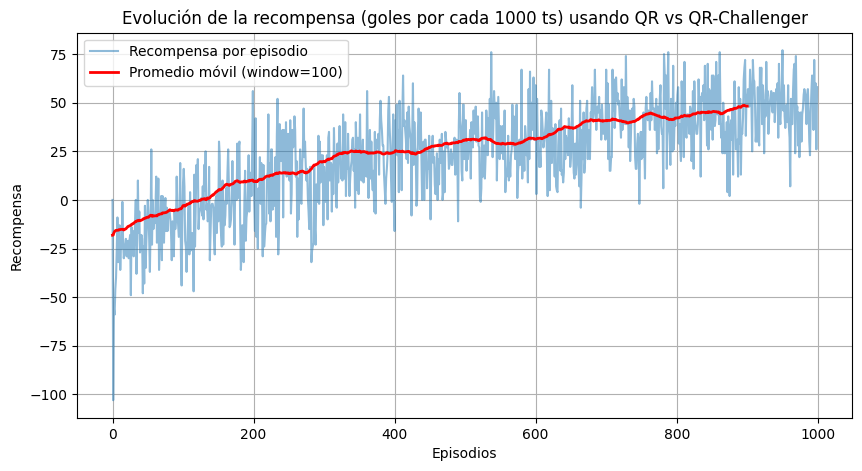

In [28]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando QR vs QR-Challenger'
plot_rewards(hist_reward_QRC,title, window_size=100)

In [31]:
run_validation(Q_table_QR, player='A', render = False, opponent = 'pi_table', pi_table_opponent= pi_table_QRC)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 23509 juegos y se ganó el 26.700412607937384% 


## QQ

In [34]:
hist_reward_QQ, q_table1_QQ, q_table2_QQ = run_qlearning_training(steps=1e6, player='A', opponent='q-learning')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 208213


In [35]:
with open("results/q_table_QQ.txt", "w") as f:
    f.write(str(q_table1_QQ))

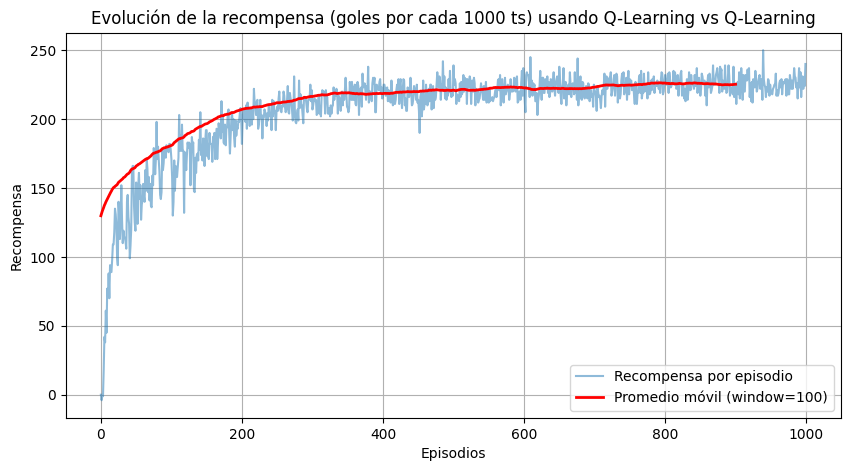

In [36]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando Q-Learning vs Q-Learning'
plot_rewards(hist_reward_QQ,title, window_size=100)

In [37]:
run_validation(q_table1_QQ, player='A', render = False, opponent = 'random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 12603 juegos y se ganó el 93.93001666269936% 


## QQ - Challenger

In [38]:
with open("results/q_table_QQ.txt", "r") as f:
    contenido = f.read()
    q_table1_QQ = eval(contenido)  # Convierte el texto de nuevo en un diccionario

In [39]:
hist_reward_QQC, q_table_QQC = run_qlearning_training(steps=1e6, player='B', opponent='pi_table', pi_table=q_table1_QQ)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


Progreso:   0%|          | 0/1000000.0 [00:00<?, ?step/s]

Played games: 190527


In [49]:
with open("results/q_table_QQC.txt", "w") as f:
    f.write(str(q_table_QQC))

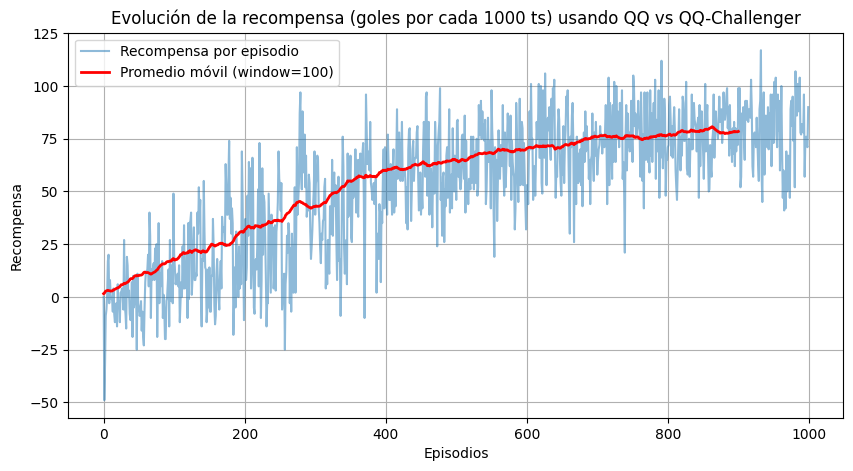

In [40]:
title = 'Evolución de la recompensa (goles por cada 1000 ts) usando QQ vs QQ-Challenger'
plot_rewards(hist_reward_QQC,title, window_size=100)

In [41]:
run_validation(q_table1_QQ, player='A', render = False, opponent = 'pi_table', pi_table_opponent= q_table_QQC)

 .   .   .   .   . 
 .   .   .   Ao  . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}
Se completaron 23545 juegos y se ganó el 26.871947334890635% 


## Evaluation

In [58]:
with open("results/pi_table_MR.txt", "r") as f:
    contenido = f.read()
    pi_table_MR = eval(contenido)  # Convierte el texto de nuevo en un diccionario

with open("results/q_table_QR.txt", "r") as f:
    contenido = f.read()
    q_table_QR = eval(contenido) 

In [53]:
run_validation(pi_table_MR, player='A', render = True, opponent = 'random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   .   Bo  .   . 
 .   .   .   .   . 
Scores: {'A': 6, 'B': 0}


KeyboardInterrupt: 

In [55]:
run_validation(q_table_QR, player='A', render = True, opponent = 'random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 7, 'B': 0}


KeyboardInterrupt: 

In [60]:
with open("results/pi_table_MRC.txt", "r") as f:
    contenido = f.read()
    # pi_table_MRC = eval(contenido)  # Convierte el texto de nuevo en un diccionario

with open("results/pi_table_QRC.txt", "r") as f:
    contenido = f.read()
    q_table_QRC = eval(contenido) 

In [61]:
run_validation(q_table_QR, player='A', render = True, opponent = 'pi_table', pi_table_opponent=q_table_QRC)

 .   .   .   .   . 
 .   .   A   .   . 
 .   .   .   Bo  . 
 .   .   .   .   . 
Scores: {'A': 5, 'B': 8}


KeyboardInterrupt: 

In [65]:
with open("results/pi_table_MM.txt", "r") as f:
    contenido = f.read()
    pi_table_MM = eval(contenido)  # Convierte el texto de nuevo en un diccionario

with open("results/q_table_QQ.txt", "r") as f:
    contenido = f.read()
    q_table_QQ = eval(contenido) 

In [63]:
run_validation(pi_table_MM, player='A', render = True, opponent = 'random')

 .   .   .   .   . 
 .   .   .   A   . 
 .   Bo  .   .   . 
 .   .   .   .   . 
Scores: {'A': 4, 'B': 0}


KeyboardInterrupt: 

In [66]:
run_validation(q_table_QQ, player='A', render = True, opponent = 'random')

 .   .   .   .   . 
 A   .   .   .   . 
 .   .   Bo  .   . 
 .   .   .   .   . 
Scores: {'A': 18, 'B': 1}


KeyboardInterrupt: 

In [67]:
with open("results/pi_table_MMC.txt", "r") as f:
    contenido = f.read()
    pi_table_MMC = eval(contenido)  # Convierte el texto de nuevo en un diccionario

with open("results/q_table_QQC.txt", "r") as f:
    contenido = f.read()
    q_table_QQC = eval(contenido) 

In [68]:
run_validation(pi_table_MM, player='A', render = True, opponent = 'pi_table', pi_table_opponent=pi_table_MMC)

 .   .   .   B   Ao
 .   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


KeyboardInterrupt: 

In [71]:
run_validation(q_table_QQ, player='A', render = True, opponent = 'pi_table', pi_table_opponent=q_table_QQC)

 .   .   .   .   . 
 .   Ao  .   .   . 
 .   B   .   .   . 
 .   .   .   .   . 
Scores: {'A': 0, 'B': 0}


KeyboardInterrupt: 